# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

###### Цель работы: построить модель для определения стоимости автомобиля.

###### Описание предоставленных данных:

Датасет содержащий  технические характеристики, комплектации и цены автомобилей. Всего 16 признаков  (включая целевой).
###### Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
###### Целевой признак
- Price — цена (евро)


###### Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

###### План работы: 
- Загрузка и подготовка данных.
- Обучение разных моделей. 
- Настройка гиперпараметров.
- Анализ скорости работы и качества моделей.

Примечания:
- Для оценки качества моделей необходимо применять метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Средствами библиотеки LightGBM построить модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook нужно получить специальной командой.
- Поскольку модель градиентного бустинга может обучаться долго, изменить у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалить лишние переменные оператором del:

### Подключение библиотек

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

import time

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

### Определение метрики

In [4]:
def rmse(y,a):
    return mse(y,a)**0.5

## Изучение и подготовка данных

In [5]:
auto = pd.read_csv('/datasets/autos.csv')

In [6]:
auto.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
auto.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
auto.shape

(354369, 16)

In [9]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

По основной статистике и информации о таблице, можно сделать следующие выводы:
 - в таблице есть пропуски
 - есть аномалии  

#### Проверка числовых признаков на аномалии

In [10]:
numeric = ['Price','RegistrationYear','Power','Kilometer']

In [17]:
def distplot_anomalies(data,numeric):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for column, ax in zip(numeric, axes.ravel()):
        ax.set_title(column)
        sns.distplot(data[column], ax=ax)
        
def boxplot_anomalies(data,numeric):    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for column, ax in zip(numeric, axes.ravel()):
        ax.set_title(column)
        sns.boxplot(data[column], ax=ax)    

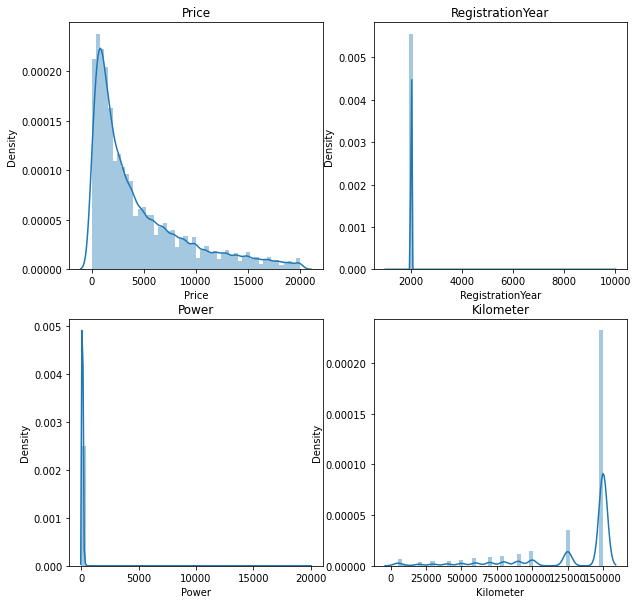

In [15]:
distplot_anomalies(auto,numeric)

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
[<AxesSubplot:title={'center':'Price'}, xlabel='Price'> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:>]
[<AxesSubplot:title={'center':'Price'}, xlabel='Price'>
 <AxesSubplot:title={'center':'RegistrationYear'}, xlabel='RegistrationYear'>
 <AxesSubplot:> <AxesSubplot:>]
[<AxesSubplot:title={'center':'Price'}, xlabel='Price'>
 <AxesSubplot:title={'center':'RegistrationYear'}, xlabel='RegistrationYear'>
 <AxesSubplot:title={'center':'Power'}, xlabel='Power'> <AxesSubplot:>]


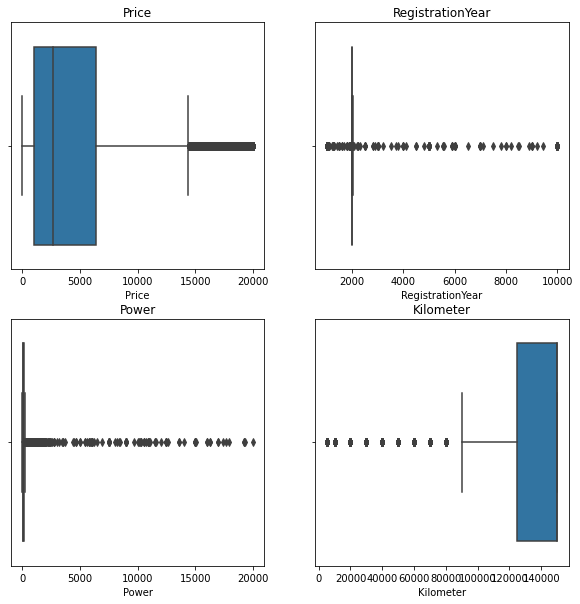

In [16]:
boxplot_anomalies(auto,numeric)

##### Аномалии по признаку 'Price'

Много авто с аномально низкой ценой. Установим допустимую цену  > 300eu.

In [12]:
auto.loc[auto['Price'] <300, 'Price'].shape[0]/auto.shape[0] # доля меньше 7% 

0.06536406965620582

In [13]:
auto = auto.loc[auto['Price'] >300]

##### Аномалии по признаку 'RegistrationYear'

Явные ошибки в указании года заменим медианой по столбцу.

In [14]:
auto.loc[(auto['RegistrationYear'] < 1990) & (auto['RegistrationYear'] >2021) , 'RegistrationYear'] = auto['RegistrationYear'].median()

##### Аномалии по признаку 'Power'

Множество нуливых значений, посмотрим их долю. 

In [15]:
auto.loc[auto['Power'] == 0].shape[0]/auto.shape[0]

0.09499048633838192

Поставим ограничение 50 л.с.

In [16]:
auto = auto.loc[auto['Power'] > 50]

##### Аномалии по признаку 'Kilometer'

Возможны продажи авто с небольшим пробегом, оставим.

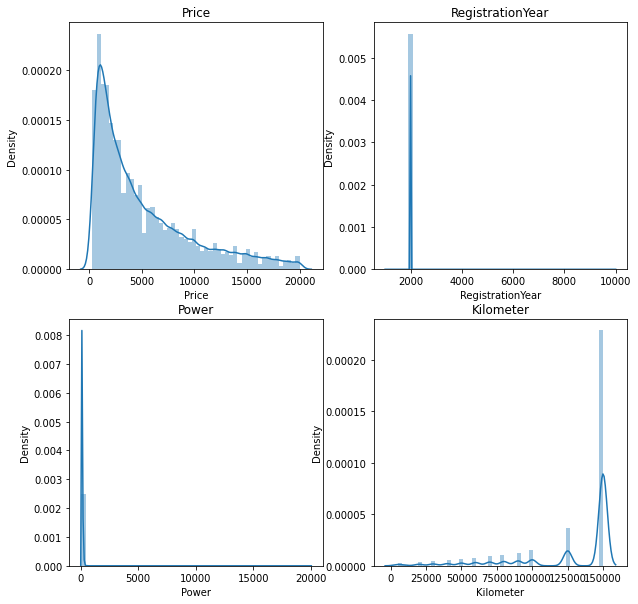

In [17]:
distplot_anomalies(auto,numeric)

#### Работа с пропусками

При выводе auto.info() видно, что в данных есть пропуски, посмотрим долю пропусков.

In [18]:
auto.isna().sum()/auto.shape[0]

DateCrawled          0.000000
Price                0.000000
VehicleType          0.065167
RegistrationYear     0.000000
Gearbox              0.017418
Power                0.000000
Model                0.037792
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.059258
Brand                0.000000
NotRepaired          0.144230
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Пропуски только в категориальных признаках. Самая существенная доля пропусков по признаку NotRepaired ~ 15%.
Заполним пропуски специальным значением 'Nan'.

In [19]:
fill_columns = ['VehicleType','Gearbox','Model','FuelType','NotRepaired']

auto[fill_columns] = auto[fill_columns].fillna('Nan') 
auto.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

#### Проверка на явные дубликаты

In [20]:
auto.duplicated().sum()

4

In [21]:
auto = auto.drop_duplicates()
auto.duplicated().sum()

0

Просмотрим категориальные признаки на наличие неявных дубликатов.

In [22]:
auto['VehicleType'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'Nan', 'other'], dtype=object)

In [23]:
auto['Gearbox'].unique()

array(['manual', 'auto', 'Nan'], dtype=object)

In [24]:
auto['Model'].unique()

array(['Nan', 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'meriva', 'other', 'c4', 'civic', 'punto', 'e_klasse',
       'clio', 'kadett', 'one', 'fortwo', '1er', 'b_klasse', 'a8',
       'jetta', 'astra', 'c_klasse', 'micra', 'vito', 'sprinter',
       'escort', 'forester', 'xc_reihe', 'fiesta', 'scenic', 'a1',
       'transporter', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega', 'polo',
       'slk', '7er', 'combo', '80', '147', 'z_reihe', 'sportage',
       'sorento', 'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia',
       'ka', 'almera', 'megane', 'a3', 'r19', 'caddy', 'corsa', 'mondeo',
       'cordoba', 'colt', 'impreza', 'vectra', 'lupo', 'berlingo',
       'tiguan', 'i_reihe', '6_reihe', 'panda', 'up', 'ceed', 'kangoo',
       '5_reihe', 'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', '6er',
       'modus', 'fox', 'matiz', 'beetle', 'rio', 'touareg', 'logan',
       'spider', 'cuor

In [25]:
auto['FuelType'].unique()

array(['gasoline', 'petrol', 'Nan', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [26]:
auto['Brand'].unique()

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'citroen',
       'honda', 'fiat', 'mini', 'smart', 'hyundai', 'seat', 'subaru',
       'volvo', 'mitsubishi', 'alfa_romeo', 'kia', 'lancia', 'toyota',
       'chevrolet', 'dacia', 'suzuki', 'daihatsu', 'chrysler',
       'sonstige_autos', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'lada', 'trabant'], dtype=object)

In [27]:
print(auto.loc[auto['Model'] == 'rangerover','Model'].shape)
auto.loc[auto['Model'] == 'rangerover','Model'] = 'range_rover'
auto.loc[auto['Model'] == 'rangerover','Model'].shape

(3,)


(0,)

#### Удаление избыточных признаков

Удалим признаки не влияющие на вывод модели.

In [28]:
columns_drop = ['DateCrawled',  'DateCreated', 'NumberOfPictures','LastSeen','PostalCode']

auto = auto.drop(columns_drop, axis=1)
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288549 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              288549 non-null  int64  
 1   VehicleType        288549 non-null  object 
 2   RegistrationYear   288549 non-null  float64
 3   Gearbox            288549 non-null  object 
 4   Power              288549 non-null  int64  
 5   Model              288549 non-null  object 
 6   Kilometer          288549 non-null  int64  
 7   RegistrationMonth  288549 non-null  int64  
 8   FuelType           288549 non-null  object 
 9   Brand              288549 non-null  object 
 10  NotRepaired        288549 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 26.4+ MB


#### Разделение данных

In [29]:
features = auto.drop('Price',axis=1)
target = auto['Price']

## Обучение моделей

#### Функция для оценки скорости работы модели
Определим функцию, опредяляющую время обучения и время предсказания.

In [30]:
def model_time_rmse(model,features_train, target_train, features_valid, target_valid):
    
    begin = time.time()
    model.fit(features_train,target_train)
    fit_time = time.time() - begin
    
    begin = time.time()
    predictions = model.predict(features_valid)
    predict_time = time.time() - begin
    
    metric = rmse(target_valid, predictions)
    return fit_time, predict_time, metric
    

#### LinearRegression
Начнем с более простой модели линейной регрессии.

Для линейной регрессии используем OHE кодирование.

In [31]:
# OHE
features_ohe = pd.get_dummies(features, drop_first=True)

In [32]:
features_ohe.shape

(288549, 309)

In [34]:
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_ohe,target,test_size=0.4,random_state=12345)
features_valid_ohe,features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(features_valid_ohe,target_valid_ohe,test_size=0.5,random_state=12345)

In [35]:
# LinearRegression
linear_reg_model = LinearRegression()


In [36]:
linear_reg_results = model_time_rmse(linear_reg_model,features_train_ohe, target_train_ohe,features_valid_ohe,target_valid_ohe)

#### CatBoostRegressor

Для этой модели не нужно использовать OHE, поэтому разделим признаки заново.

In [37]:
features_train, features_valid, target_train, target_valid = train_test_split(features,target,test_size=0.4,random_state=12345)
features_valid,features_test, target_valid, target_test = train_test_split(features_valid,target_valid,test_size=0.5,random_state=12345)

In [38]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173129 entries, 229092 to 267224
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VehicleType        173129 non-null  object 
 1   RegistrationYear   173129 non-null  float64
 2   Gearbox            173129 non-null  object 
 3   Power              173129 non-null  int64  
 4   Model              173129 non-null  object 
 5   Kilometer          173129 non-null  int64  
 6   RegistrationMonth  173129 non-null  int64  
 7   FuelType           173129 non-null  object 
 8   Brand              173129 non-null  object 
 9   NotRepaired        173129 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 14.5+ MB


In [39]:
cat_model = CatBoostRegressor(loss_function="RMSE", iterations=50, random_state=12345)

In [40]:
cat_features = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
ignored_features = ['RegistrationMonth','Gearbox','FuelType']

In [41]:
def model_time_rmse_cat(model,features_train, target_train, features_valid, target_valid,cat_features):
    
    begin = time.time()
    model.fit(features_train,target_train,cat_features=cat_features, verbose=10)
    fit_time = time.time() - begin
    
    begin = time.time()
    predictions = model.predict(features_valid)
    predict_time = time.time() - begin
    
    metric = rmse(target_valid, predictions)
    return fit_time, predict_time, metric

In [42]:
model_time_rmse_cat(cat_model,features_train, target_train, features_valid, target_valid,cat_features)

Learning rate set to 0.5
0:	learn: 3348.8451754	total: 145ms	remaining: 7.09s
10:	learn: 1932.7180039	total: 906ms	remaining: 3.21s
20:	learn: 1828.0117924	total: 1.6s	remaining: 2.21s
30:	learn: 1771.9192215	total: 2.25s	remaining: 1.38s
40:	learn: 1736.1506209	total: 2.95s	remaining: 648ms
49:	learn: 1713.4967670	total: 3.71s	remaining: 0us


(4.612110376358032, 0.09244990348815918, 1740.6309260838098)

In [43]:
# Функцию нагуглила
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

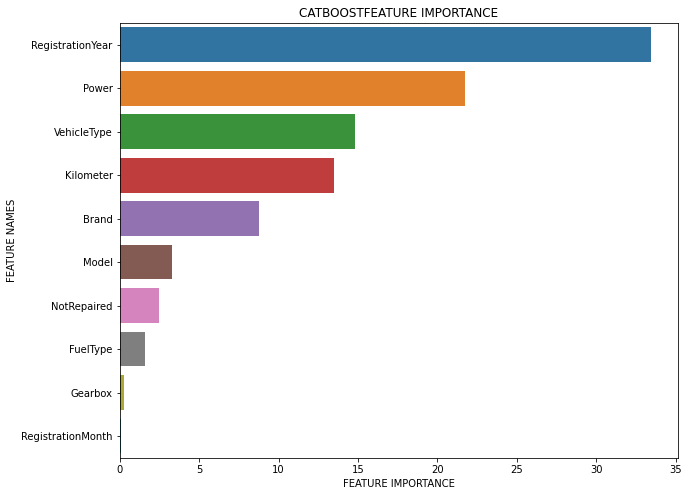

In [44]:
plot_feature_importance(cat_model.get_feature_importance(),features_train.columns,'CATBOOST')

Можно добавить игнорирование наименее значимых признаков.

In [45]:
cat_model = CatBoostRegressor(loss_function="RMSE", iterations=50, random_state=12345,ignored_features=ignored_features)

In [46]:
model_time_rmse_cat(cat_model,features_train, target_train, features_valid, target_valid,cat_features)

Learning rate set to 0.5
0:	learn: 3319.7283748	total: 68.6ms	remaining: 3.36s
10:	learn: 1948.0404841	total: 615ms	remaining: 2.18s
20:	learn: 1853.8813965	total: 1.12s	remaining: 1.55s
30:	learn: 1805.9872389	total: 1.68s	remaining: 1.03s
40:	learn: 1766.6720293	total: 2.29s	remaining: 503ms
49:	learn: 1743.0871636	total: 2.78s	remaining: 0us


(3.6574175357818604, 0.07226753234863281, 1758.0286067800373)

Воспользуемся кросс-валидацией GridSearchCV: для данной модели.

In [ ]:
model = CatBoostRegressor() 
params = {'learning_rate': [0.03, 0.1],
          'depth': [4, 6, 10],
          'l2_leaf_reg': [1, 3, 5, 7, 9]
         }

grid = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train,cat_features=cat_features)

print('Лучшие параметры',grid.best_params_)

Лучшие параметры {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [53]:
cat_model = CatBoostRegressor(loss_function="RMSE", iterations=50, random_state=12345,ignored_features=ignored_features,depth=10,learning_rate=0.1,l2_leaf_reg=1)

In [54]:
cat_model_results = model_time_rmse_cat(cat_model,features_train, target_train, features_valid, target_valid,cat_features)

0:	learn: 4286.2730288	total: 106ms	remaining: 5.2s
10:	learn: 2572.2152973	total: 1.02s	remaining: 3.62s
20:	learn: 2035.3225475	total: 1.9s	remaining: 2.63s
30:	learn: 1868.1747959	total: 2.79s	remaining: 1.71s
40:	learn: 1804.6754747	total: 3.73s	remaining: 819ms
49:	learn: 1773.2330088	total: 4.56s	remaining: 0us


#### LightGBM 

In [49]:
lgbm_model = LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=20, random_state=12345)

In [51]:
lgbm_model_results = model_time_rmse(lgbm_model, features_train_ohe, target_train_ohe,features_valid_ohe,target_valid_ohe)

## Прогон на тестовой выборке

In [57]:
test_result_linear_reg = model_time_rmse(linear_reg_model,features_train_ohe, target_train_ohe,features_test_ohe,target_test_ohe)

In [59]:
test_result_linear_reg

(57.74160122871399, 0.24706673622131348, 3109.254216652626)

In [60]:
test_result_catboost = model_time_rmse_cat(cat_model,features_train, target_train, features_test, target_test,cat_features)
test_result_catboost

0:	learn: 4286.2730288	total: 132ms	remaining: 6.47s
10:	learn: 2572.2152973	total: 1.08s	remaining: 3.82s
20:	learn: 2035.3225475	total: 2.08s	remaining: 2.87s
30:	learn: 1868.1747959	total: 3.06s	remaining: 1.88s
40:	learn: 1804.6754747	total: 3.98s	remaining: 873ms
49:	learn: 1773.2330088	total: 4.86s	remaining: 0us


(5.77178430557251, 0.0831754207611084, 1779.6714154159783)

In [61]:
test_result_lgbm =  model_time_rmse(lgbm_model, features_train_ohe, target_train_ohe, features_test_ohe, target_test_ohe)
test_result_lgbm

(77.1848828792572, 0.3994452953338623, 2098.0084189800314)

## Анализ моделей

In [55]:
result_models = {'LinearRegression':linear_reg_results,'CatBoostRegressor':cat_model_results,'LGBMRegressor':lgbm_model_results}
results =  pd.DataFrame(result_models)

In [56]:
results

,LinearRegression,CatBoostRegressor,LGBMRegressor
0,33.864555,5.416279,98.321703
1,0.183017,0.080854,0.315523
2,3140.245283,1787.690238,2106.557580


In [62]:
test_result_models = {'LinearRegression':test_result_linear_reg,'CatBoostRegressor':test_result_catboost,'LGBMRegressor':test_result_lgbm}
test_results =  pd.DataFrame(test_result_models)
test_results

,LinearRegression,CatBoostRegressor,LGBMRegressor
0,57.741601,5.771784,77.184883
1,0.247067,0.083175,0.399445
2,3109.254217,1779.671415,2098.008419


#### Вывод: на основе результатов, предпочтительно использовать модель CatBoostRegressor.

Результаты на валидационной выборке:

- Скорость обучения:  5.416279	
- Скорость предсказания: 0.08085
- RMSE: 1787.690238		

Результаты на тестовой выборке:

- Скорость обучения:  5.771784
- Скорость предсказания: 0.083175
- RMSE: 1779.671415			



Модель LGBMRegressor показывает также неплохие результаты, незначительно уступает CatBoostRegressor по выбранной метрике, но сильно уступает по скорости обучения.


В ходе работы было сделано:

- Загрузка и подготовка данных.
- Обучение разных моделей. 
- Настройка гиперпараметров для модели CatBoostRegressor.
- Анализ скорости работы и качества моделей.
